In [34]:
import gym
from envs.gridworld import GridworldEnv
import numpy as np
from collections import defaultdict
from utils import show_grid
%matplotlib inline

In [3]:
env = GridworldEnv()

When we have the complete model of the MDP, we can use DP to find an optimal policy. 

## Policy Evaluation 

Given a random policy to navigate the gridworld we can evaluate this policy by the following algorithm:

In [4]:
def policy_evaluation(env, policy, theta=0.0001, discount=0.99):
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            v = 0
            for a, p_a in enumerate(policy[s]):
                for p, s_, r, done in env.P[s][a]:
                    v += p_a * p * (r + discount * V[s_])

            delta = max(delta, np.abs(v - V[s]))
            V[s] = v

        if delta < theta:
            break
    return V

First we generate a random policy:

In [6]:
random_policy = np.ones((env.nS, env.nA)) / env.nA

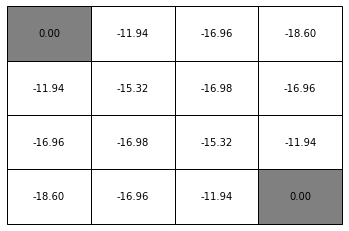

In [7]:
V = policy_evaluation(env, random_policy)
show_grid(V.reshape(4,4))

## Moving on to Monte Carlo

By the model of the environment we mean `env.P`. So for each state, for each action we know the next state, transition probability, and the reward (and done flag, meaning if its the goal state). If we do not have this model then the DP methods do not work for finding new policies. Before moving onto finding a good policy in model-free setting, let us see how to evalute state values using motecarlo method. 

We will still operate in the same gridworld environment but ignore that we have the model available. Instead of relying on `env.P` we will take randomly start off at a state `s` and take random action `a`. Thus generate trajectories. In each trajectory we find the first occurance of a state `s`, from that step onwards compute the total reward, and record this reward for the state `s`. 

In the end the value estimate of a given state is the total reward for that state divided by the total first-visits to that state. 

In [41]:
def pick_action(env):
    return np.random.choice(env.nA)

def MC_value_estimate(env, n_episodes, discount=0.99):
    val_estimates = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    for ep in range(n_episodes):
        trajectory = []
        s = env.reset()
        done = False
        while not done:
            s = env.s
            a = pick_action(env)
            s_, r, done, _ = env.step(a)
            trajectory.append((s,a,r))

        visited_states = set([x[0] for x in trajectory])
        for s in visited_states:
            first_visit_idx = next(i for i,x in enumerate(trajectory) if x[0] == s)
            G = sum(x[2]*(discount**i) for i,x in enumerate(trajectory[first_visit_idx:]))
            returns_sum[s] += G
            returns_count[s] += 1.0
            val_estimates[s] = returns_sum[s] /returns_count[s]
            
    return np.array([val_estimates[i] for i in range(env.nS)])

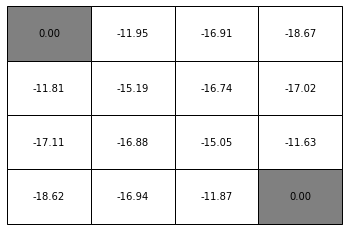

In [43]:
V = MC_value_estimate(env, n_episodes=10000)
show_grid(V.reshape(4,4))

We can see that the state values are approximately the same as the ones we computed following a random policy in policy evaluation. 

## Policy Improvement

Coming back to the model-equipped scenario, we want to improve on that random policy we just evaluated. Once we evaluate a policy its easy to improve it. For each state we look for the action which gives us the highest return (this is reward plus gamma times value of next state i.e. $ p(s',r | s,\pi(s)) \cdot [r + \gamma V(s')]$ ) for each  

In [28]:

def policy_iteration(env, policy, discount=0.99):
    
    while True:
        V = policy_evaluation(env, policy)
        
        policy_stable = True
        for s in range(env.nS):
            old_a = np.argmax(policy[s])
        
            action_values = np.zeros(env.nA)
            for a in range(env.nA):
                for p, s_, r, done in env.P[s][a]:
                    action_values[a] += p * (r + discount * V[s_])
            
            new_a = np.argmax(action_values)
            
            policy[s] = np.eye(env.nA)[new_a]

            if old_a != new_a:
                policy_stable = False
            
        if policy_stable:
            return V, policy

In [29]:
V, P = policy_iteration(env, random_policy)